# **Homework 2 - Classification**

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。



In [1]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz
!ls

acc.png  data.tar.gz	 hw2_classification.ipynb  submit.csv
data	 generative.csv  loss.png


# Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我們會實作 logistic regression，針對理論細節說明請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=hSXFuypLukA)

### Preparing Data

Load and normalize data, and then split training data into training set and development set.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

In [3]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    
X_train

array([[33.,  1.,  0., ..., 52.,  0.,  1.],
       [63.,  1.,  0., ..., 52.,  0.,  1.],
       [71.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [16.,  0.,  0., ...,  8.,  1.,  0.],
       [48.,  1.,  0., ..., 52.,  0.,  1.],
       [48.,  0.,  0., ...,  0.,  0.,  1.]])

In [4]:
X_train = pd.read_csv(X_train_fpath)
Y_train = pd.read_csv(Y_train_fpath)
X_test = pd.read_csv(X_test_fpath)

X_train.head()

,id,age,Private,Self-employed-incorporated,State government,Self-employed-not incorporated,Not in universe,Without pay,Federal government,Never worked,...,1.2,Not in universe.12,Yes.3,No.3,2.3,0.3,1.3,weeks worked in year,94,95
0,0,33,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
1,1,63,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
2,2,71,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,43,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
4,4,57,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1


In [5]:
# remove id column
X_train = X_train.iloc[:, 1:] 
Y_train = Y_train.iloc[:, 1] 
X_test = X_test.iloc[:, 1:] 


# DataFrame to_csv
X_train = X_train.to_numpy(dtype=float)
Y_train = Y_train.to_numpy(dtype=float)
X_test = X_test.to_numpy(dtype=float)
X_train

array([[33.,  1.,  0., ..., 52.,  0.,  1.],
       [63.,  1.,  0., ..., 52.,  0.,  1.],
       [71.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [16.,  0.,  0., ...,  8.,  1.,  0.],
       [48.,  1.,  0., ..., 52.,  0.,  1.],
       [48.,  0.,  0., ...,  0.,  0.,  1.]])

In [6]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

# Normalize training and testing data
# X_train, X_mean, X_std = _normalize(X_train, specified_column = list(i for i in range(X_train.shape[1])) , train = True)
X_train, X_mean, X_std = _normalize(X_train, train = True) # create mean, var from train set
X_train.shape

(54256, 510)

In [7]:
# use mean, var from train set
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
X_test.shape

(27622, 510)

In [8]:
from sklearn.model_selection import train_test_split

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Split data into training set and development set
dev_ratio = 0.1
# X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train, test_size=dev_ratio)  # API method
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

In [9]:
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


### Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

### sigmoid
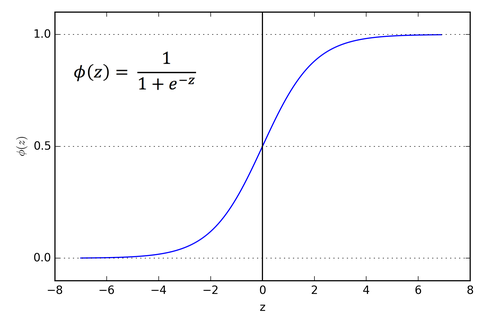

### f
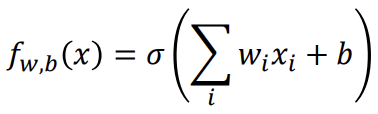

In [10]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。


### Binary Cross-Entropy Loss
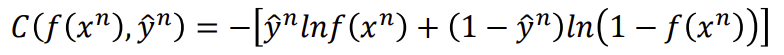

### gradient
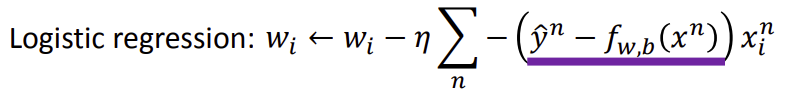

In [11]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1) # dot( (y' -y), X_T )
    b_grad = -np.sum(pred_error)          # - sum(y' -y)
    return w_grad, b_grad

In [12]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad
        
        step = step + 1     
        
    # Compute loss and accuracy of training set and development set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)
    
    print('Epoch : {}, Step : {}, Loss : {:.2f} '.format(epoch, step, train_loss[-1]))
    
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Epoch : 0, Step : 6104, Loss : 0.31 
Epoch : 1, Step : 12207, Loss : 0.29 
Epoch : 2, Step : 18310, Loss : 0.29 
Epoch : 3, Step : 24413, Loss : 0.28 
Epoch : 4, Step : 30516, Loss : 0.28 
Epoch : 5, Step : 36619, Loss : 0.28 
Epoch : 6, Step : 42722, Loss : 0.27 
Epoch : 7, Step : 48825, Loss : 0.27 
Epoch : 8, Step : 54928, Loss : 0.27 
Epoch : 9, Step : 61031, Loss : 0.27 
Training loss: 0.271355435246406
Development loss: 0.2896359675026287
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


### Plotting Loss and accuracy curve

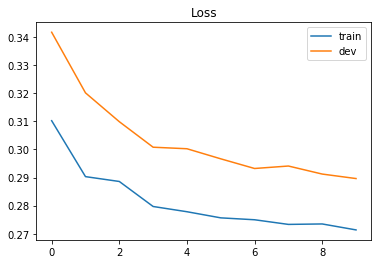

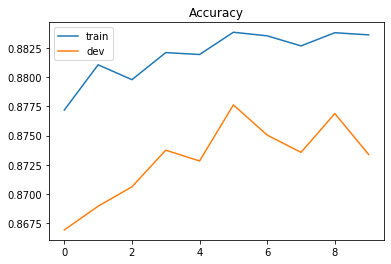

In [13]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

### Predicting testing labels

Predictions are saved to *output_logistic.csv*.

預測測試集的資料標籤並且存在 *output_logistic.csv* 中。

In [14]:
# simple
dtypes = np.dtype(
    [
        ("id", str),
        ("label", int)       
    ]
)
submit_file = pd.DataFrame(np.empty(0, dtype=dtypes))

predictions = _predict(X_test, w, b)
for i, label in  enumerate(predictions):
    row = {'id': 'id_' + str(i), "label" : label }
    submit_file = submit_file.append(row, ignore_index=True)
submit_file.to_csv('submit.csv', index=False)

In [15]:
# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1] # sort from big to small
content = pd.read_csv(X_test_fpath)
features = content.columns
# with open(X_test_fpath) as f:
#     content = f.readline().strip('\n').split(',')
# features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019251
 Spouse of householder -1.625403958705141
 Other Rel <18 never married RP of subfamily -1.4195759775765404
 Child 18+ ever marr Not in a subfamily -1.2958572076664745
 Unemployed full-time 1.1712558285885912
 Other Rel <18 ever marr RP of subfamily -1.167791807296237
 Italy.1 -1.093458143800618
 Vietnam -1.0630365633146415
num persons worked for employer 0.938992277356651
 1.3 0.8226614922117185


# Porbabilistic generative model

In this section we will discuss a generative approach to binary classification. Again, we will not go through the formulation detailedly. Please find [Prof. Lee's lecture](https://www.youtube.com/watch?v=fZAZUYEeIMg) if you are interested in it.

接者我們將實作基於 generative model 的二元分類器，理論細節請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=fZAZUYEeIMg)。

### Preparing Data

Training and testing data is loaded and normalized as in logistic regression. However, since LDA is a deterministic algorithm, there is no need to build a development set.

訓練集與測試集的處理方法跟 logistic regression 一模一樣，然而因為 generative model 有可解析的最佳解，因此不必使用到 development set。

In [16]:
X_train = pd.read_csv(X_train_fpath)
Y_train = pd.read_csv(Y_train_fpath)
X_test = pd.read_csv(X_test_fpath)

# remove id column
X_train = X_train.iloc[:, 1:] 
Y_train = Y_train.iloc[:, 1] 
X_test = X_test.iloc[:, 1:] 


# DataFrame to_csv
X_train = X_train.to_numpy(dtype=float)
Y_train = Y_train.to_numpy(dtype=float)
X_test = X_test.to_numpy(dtype=float)


# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### Mean and Covariance

In generative model, in-class mean and covariance are needed.

在 generative model 中，我們需要分別計算兩個類別內的資料平均與共變異。


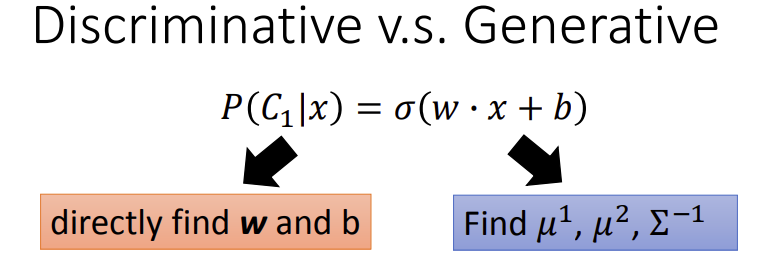

Find 𝜇1, 𝜇2, share covarience matrix(Σ^−1)

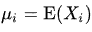
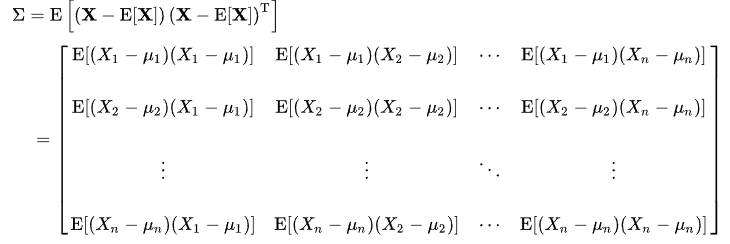

In [17]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0) 

In [18]:
# Compute in-class covariance
# Σ 是半正定的和對稱的矩陣 (data_dim X data_dim)
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

In [19]:
# Shared covariance is taken as a weighted average of individual in-class covariance.
num_0 = X_train_0.shape[0]
num_1 = X_train_1.shape[0]
cov = (cov_0 * num_0 + cov_1 * num_1) / (num_0 + num_1)

### Computing weights and bias

Directly compute weights and bias from in-class mean and shared variance. [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)(p.33) gives a concise explanation.

權重矩陣與偏差向量可以直接被計算出來，算法可以參考[李宏毅老師教學投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)第 33 頁。

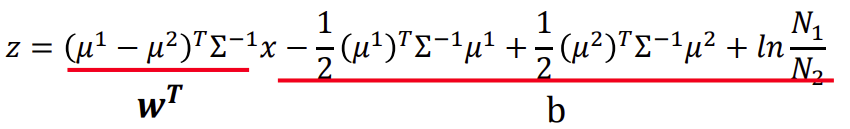

#### 奇異值分解 (SVD)
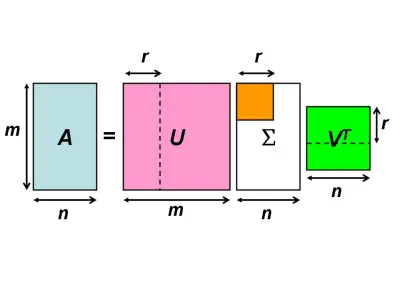
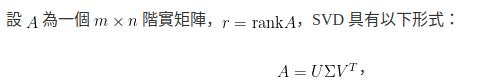

#### np.linalg.svd
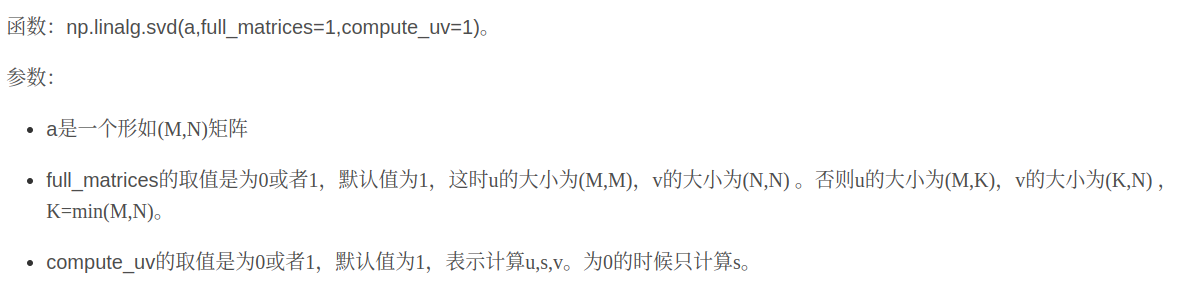

In [20]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False) 
print("u: ", u.shape)
print("s: ", s.shape)
print("v: ", v.shape)

# dot(B, A) = A_T * B
# matmul(B, A_T) = A * B

recover1 = np.matmul(v.T * s, u.T)     # A = matmul(u, v.T * s)
recover2 = (v.T * s) @ u.T             # A = matmul(u, v.T * s)
recover3 = s * v.T  @ u.T              # A = s * matmul(u, v.T)
recover4 = np.dot(s * v.T, u.T)        # A = s * dot(u, s * v.T)

inv = np.matmul(v.T * 1 / s, u.T)

print("inv: ", inv.shape)

print("recover1 equal: ", np.array_equal(recover1, recover1))
print("recover2 equal: ", np.array_equal(recover1, recover2))
print("recover3 equal: ", np.array_equal(recover1, recover3))
print("recover4 equal: ", np.array_equal(recover1, recover4))

u:  (510, 510)
s:  (510,)
v:  (510, 510)
inv:  (510, 510)
recover1 equal:  True
recover2 equal:  True
recover3 equal:  True
recover4 equal:  True


In [21]:
recover1

array([[ 0.97796336, -0.16810408,  0.02986219, ..., -0.07983857,
        -0.02807772,  0.02807772],
       [-0.16810408,  0.99154044, -0.19823935, ...,  0.48773055,
        -0.02450272,  0.02450272],
       [ 0.02986219, -0.19823935,  0.97001985, ...,  0.07409483,
         0.00484927, -0.00484927],
       ...,
       [-0.07983857,  0.48773055,  0.07409483, ...,  0.89572619,
        -0.02888793,  0.02888793],
       [-0.02807772, -0.02450272,  0.00484927, ..., -0.02888793,
         0.99868338, -0.99868338],
       [ 0.02807772,  0.02450272, -0.00484927, ...,  0.02888793,
        -0.99868338,  0.99868338]])

In [22]:
cov

array([[ 0.97796336, -0.16810408,  0.02986219, ..., -0.07983857,
        -0.02807772,  0.02807772],
       [-0.16810408,  0.99154044, -0.19823935, ...,  0.48773055,
        -0.02450272,  0.02450272],
       [ 0.02986219, -0.19823935,  0.97001985, ...,  0.07409483,
         0.00484927, -0.00484927],
       ...,
       [-0.07983857,  0.48773055,  0.07409483, ...,  0.89572619,
        -0.02888793,  0.02888793],
       [-0.02807772, -0.02450272,  0.00484927, ..., -0.02888793,
         0.99868338, -0.99868338],
       [ 0.02807772,  0.02450272, -0.00484927, ...,  0.02888793,
        -0.99868338,  0.99868338]])

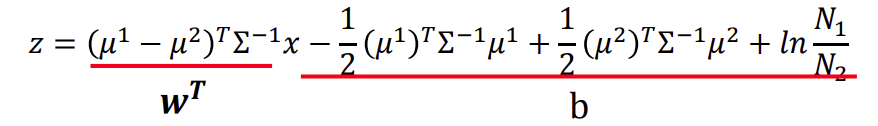

In [23]:
# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
# w = np.matmul(inv, mean_0 - mean_1) # equal

b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b) # true-1 for 0 , non-true-0 for 1
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))
unique, counts = np.unique(Y_train_pred, return_counts=True)
print('0: {}, 1: {}'.format(counts[0], counts[1]) ) 

Training accuracy: 0.8719588616927161
0: 44298, 1: 9958


### Predicting testing labels

Predictions are saved to *output_generative.csv*.

預測測試集的資料標籤並且存在 *output_generative.csv* 中。

In [24]:
# simple
dtypes = np.dtype(
    [
        ("id", str),
        ("label", int)       
    ]
)
generative = pd.DataFrame(np.empty(0, dtype=dtypes))

# Predict testing labels
predictions = 1 - _predict(X_test, w, b)

for i, label in  enumerate(predictions):
    row = {'id': 'id_' + str(i), "label" : label }
    submit_file = submit_file.append(row, ignore_index=True)
generative.to_csv('generative.csv', index=False)

In [25]:
# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1] # sort from big to small
content = pd.read_csv(X_test_fpath)
features = content.columns
# with open(X_test_fpath) as f:
#     content = f.readline().strip('\n').split(',')
# features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 7.980224609375
 34 -6.096435546875
 37 -5.639404296875
 Transportation 5.28515625
 19 -5.21484375
 Other service -5.209716796875
 Different state same division -4.74609375
 Other Rel 18+ never marr RP of subfamily 4.28515625
 32 4.0625
 Medical except hospital -3.939453125
